In [7]:
# Instalación de la librería necesaria
%pip install gymnasium[toy_text]
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

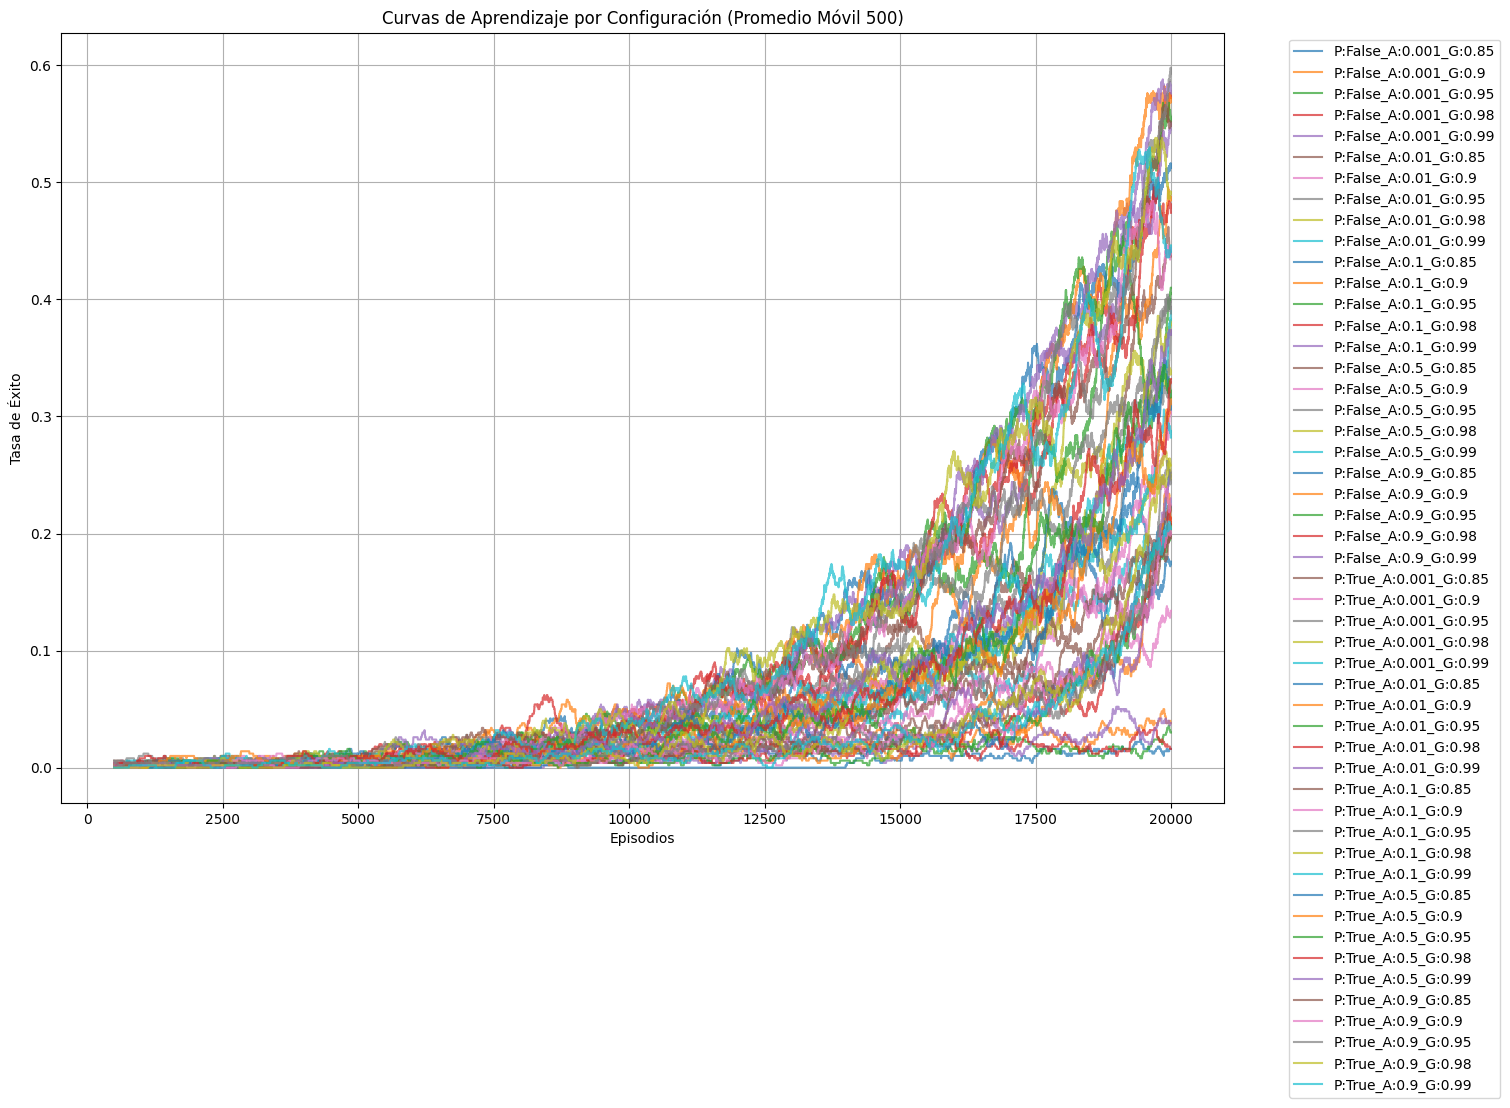

In [9]:
def train_agent(alpha, gamma, use_penalty=False, episodes=20000):
    env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=True)
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    
    epsilon = 1.0
    epsilon_decay = 1.0 / episodes
    rng = np.random.default_rng()
    
    rewards_history = []
    steps_history = []
    first_success = episodes # Default si nunca llega
    
    for i in range(episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        step_count = 0
        
        while not (terminated or truncated):
            if rng.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])
            
            next_state, reward, terminated, truncated, _ = env.step(action)
            
            # Penalización opcional
            mod_reward = reward
            if use_penalty and terminated and reward == 0:
                mod_reward = -1.0
            
            # Bellman
            q_table[state, action] += alpha * (mod_reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action])
            
            state = next_state
            step_count += 1
            
            if reward == 1 and first_success == episodes:
                first_success = i
        
        epsilon = max(epsilon - epsilon_decay, 0.01)
        rewards_history.append(reward)
        steps_history.append(step_count)
        
    env.close()
    return rewards_history, steps_history, q_table, first_success

# --- EJECUCIÓN DEL BARRIDO ---
alphas = [0.001, 0.01, 0.1, 0.5, 0.9]
gammas = [0.85, 0.9, 0.95, 0.98, 0.99]
penalty_modes = [False, True]
all_results = []
best_q = None
max_reward = -1

plt.figure(figsize=(15, 10))

for p_mode in penalty_modes:
    for a, g in itertools.product(alphas, gammas):
        label = f"P:{p_mode}_A:{a}_G:{g}"
        history, steps, q, conv = train_agent(a, g, use_penalty=p_mode)
        
        avg_last_100 = np.mean(history[-100:])
        
        # Guardar mejor tabla para el Heatmap
        if avg_last_100 > max_reward:
            max_reward = avg_last_100
            best_q = q
            best_params = label
        
        all_results.append({
            'Penalizacion': p_mode, 'Alpha': a, 'Gamma': g,
            'Exito_Final': avg_last_100, 'Pasos_Promedio': np.mean(steps),
            'Episodio_Convergencia': conv, 'Estabilidad_Std': np.std(history[-100:])
        })
        
        # Gráfica de Recompensa Acumulada (Suavizada)
        res_smooth = pd.Series(history).rolling(window=500).mean()
        plt.plot(res_smooth, label=label, alpha=0.7)

plt.title('Curvas de Aprendizaje por Configuración (Promedio Móvil 500)')
plt.xlabel('Episodios')
plt.ylabel('Tasa de Éxito')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

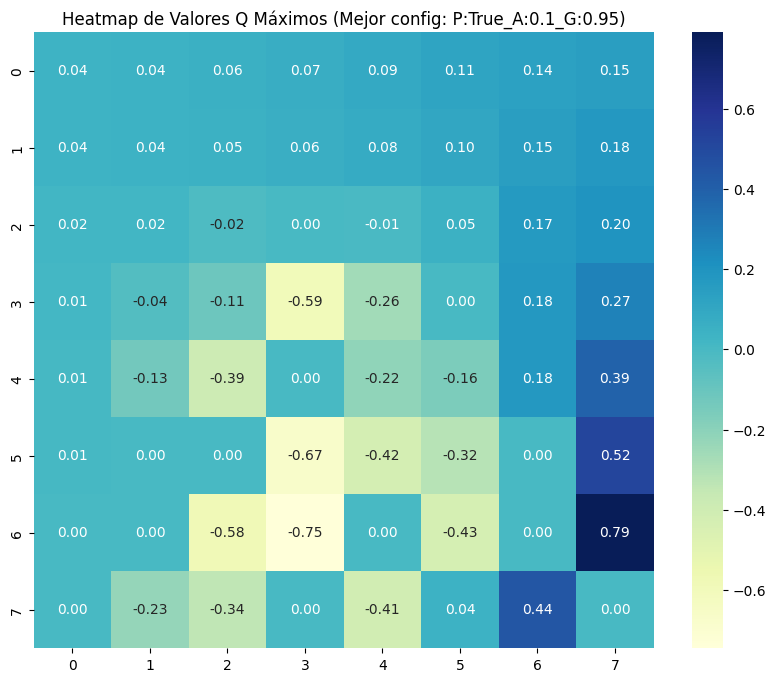

Experimento terminado. Revisa el CSV y las gráficas.


In [10]:
# --- GENERAR CSV ---
df = pd.DataFrame(all_results)
df.to_csv('datos_experimentales_completos.csv', index=False)

# --- VISUALIZACIÓN: HEATMAP DE LA TABLA Q ---
plt.figure(figsize=(10, 8))
# Tomamos el valor máximo de acción para cada estado y lo redimensionamos a 8x8
q_map = np.max(best_q, axis=1).reshape(8, 8)
sns.heatmap(q_map, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title(f"Heatmap de Valores Q Máximos (Mejor config: {best_params})")
plt.show()

print("Experimento terminado. Revisa el CSV y las gráficas.")